In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
import random
import arviz as az
import pymc as pm
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import cell_decomp_func as cdfn

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/sphere/dburrows12/'
s_data = '/sphere/dburrows12/'

%load_ext autoreload
sys.version

'3.9.16 (main, Jan 11 2023, 16:05:54) \n[GCC 11.2.0]'

In [17]:
# CPMs
%autoreload
#Define parameters of simulated data
n_clusts = 5
n_genes = 800
n_cells = 100
rate_range = 0,40 #max and min of uniform distribution for generating rates
per = 55 #percentage of dropped genes
e_std= 0 #spot + gene noise
g_std = 5 #gene specific noise
a_std = 0 #spot specific noise

In [22]:
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']
prop_vec = spot_sim.__dict__['prop_vec']

#Dropout a certain percentage of genes
for i in range(spots.shape[0]):
    rand_ind = np.random.choice(np.arange(spots.shape[1]), size = int((per/100) * spots.shape[1]), replace=False) #random index for selecting
    spots[i,rand_ind]=0
    
#gamma - over each gene
gamma = np.random.normal(0, g_std, (spots.shape[1]))
gamma_mat = np.asarray([gamma for i in range(spots.shape[0])]) #Repeat across columns for elementwise addition
spots = spots+gamma_mat

spots = spots.astype(int) 
spots[spots < 0] = 0
spots +=1 #remove any zeros

Loaded parameters: 5 cell types , 100 cells, & 800 genes.
Created spot mixtures from simulated data: 35 spots.


In [23]:
#Simple Linear regression

with pm.Model(coords={"celltypes": np.arange(n_clusts),
                      "spots": np.arange(n_spots),
                      "genes": np.arange(n_genes) }) as basic_model:
    
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes'])
    
    lmd= pm.Deterministic('lmd', pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

In [24]:
#Run model
with basic_model:
    idata=pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 67 tune and 0 draw iterations (67 + 0 draws total) took 96 seconds.
/sphere/dburrows12/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (67) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [ ]:
#Poisson noise
with pm.Model(coords={"celltypes": np.arange(n_clusts),
                      "spots": np.arange(n_spots),
                      "genes": np.arange(n_genes),
                       "1": np.arange(1) }) as Poisson_noise_model:
    
    #Declare data 
    mean_exp = pm.Data('mean_exp', ref_exp, mutable=False, dims=['celltypes','genes'])
    
    # Priors for unknown model parameters
    beta=pm.HalfNormal("beta", sigma=1, dims=['spots','celltypes']) # celltype proportions
    #alpha = pm.Normal("alpha", mu=0, sigma=0.1, dims=['spots','1']) # random noise at each spot
    gamma = pm.Normal("gamma", mu= 0, sigma=0.1, dims=['1', 'genes']) # random noise at each gene

    lmd= pm.Deterministic('lmd', np.exp(gamma)*pm.math.dot(beta, mean_exp), dims=['spots','genes'])
    
    #Convert from proportions to counts
    N_g = pm.Data('N_g', np.sum(spots, 1).reshape(n_spots,1), mutable=False)

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N_g, observed=spots)

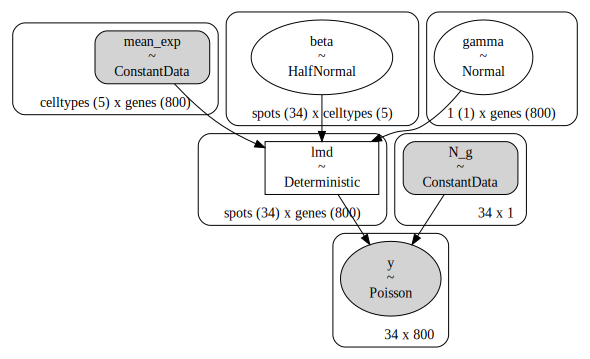

In [7]:
pm.model_to_graphviz(Poisson_noise_model)

In [8]:
with Poisson_noise_model:
    idata = pm.sample(random_seed=1,draws=200,chains=1, discard_tuned_samples=False)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta, gamma]


Sampling 1 chain for 1_000 tune and 200 draw iterations (1_000 + 200 draws total) took 60 seconds.
/sphere/dburrows12/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (200) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/sphere/dburrows12/anaconda3/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


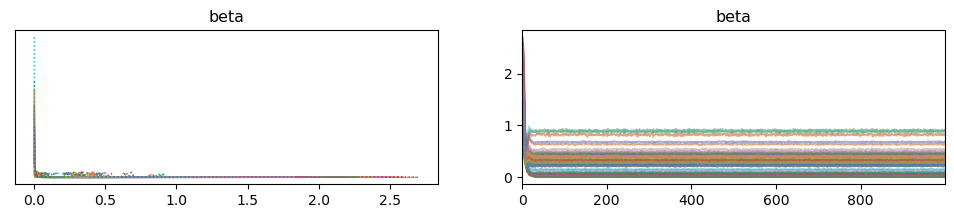

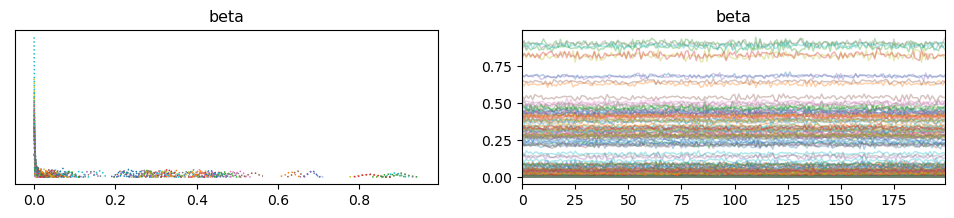

In [11]:
az.plot_trace(idata.warmup_posterior,var_names=('beta'), kind='trace',compact=True,combined=True);
az.plot_trace(idata.posterior,var_names=('beta'),compact=True,combined=True);

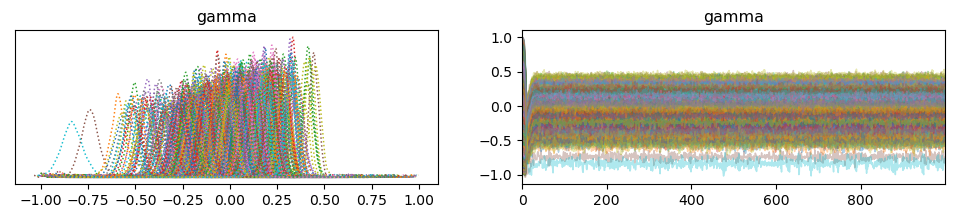

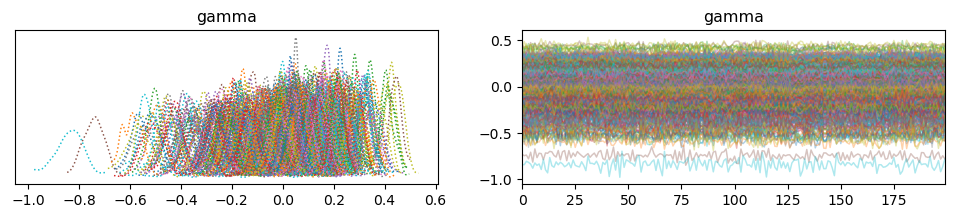

In [12]:
az.plot_trace(idata.warmup_posterior,var_names=('gamma'), kind='trace',compact=True,combined=True);
az.plot_trace(idata.posterior,var_names=('gamma'),compact=True,combined=True);

In [10]:
line_fit.rvalue**2

0.9751490262489452

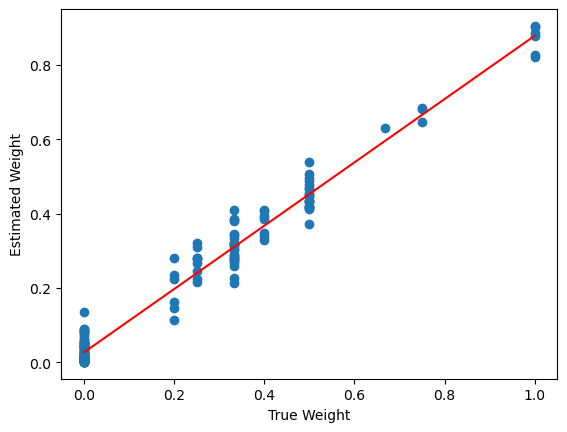

In [9]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

from scipy.stats import linregress

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

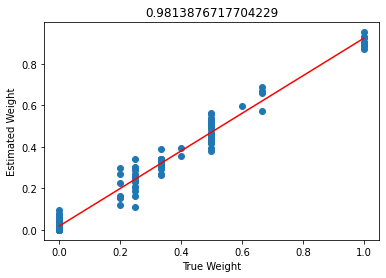

In [45]:
from scipy.stats import linregress

#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)
plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
 
corr_matrix = np.corrcoef(np.ravel(prop_vec), np.ravel(mean_post)) 
corr = corr_matrix[0,1]
R_sq = corr**2
plt.title(R_sq)
plt.show()

In [35]:
#Simple Linear regression

basic_model=pm.Model()

with basic_model:
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    lmd=pm.math.dot(beta, ref_exp)  
    N=np.sum(spots, 1).reshape(n_spots,1)
    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd*N, observed=spots)

In [36]:
#Run model
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 121 seconds.


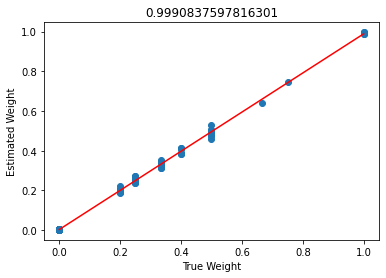

In [38]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

from scipy.stats import linregress
mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
 
corr_matrix = np.corrcoef(np.ravel(prop_vec), np.ravel(mean_post)) 
corr = corr_matrix[0,1]
R_sq = corr**2
plt.title(R_sq)
plt.show()

In [4]:
#Simulate spot data from simulated gene expression
spot_sim = cdfn.simulate_cell_mix(n_clusts, n_cells, n_genes).simulate_gene_exp(rate_range)
n_spots = spot_sim.__dict__['n_spots']
spots = spot_sim.__dict__['spots']
ref_exp = spot_sim.__dict__['mean_exps']
prop_vec = spot_sim.__dict__['prop_vec']

#Dropout a certain percentage of genes
for i in range(spots.shape[0]):
    rand_ind = np.random.choice(np.arange(spots.shape[1]), size = int((per/100) * spots.shape[1]), replace=False) #random index for selecting
    spots[i,rand_ind]=0

#Add random noise and make int and remove negatives
#spots = spots+np.random.normal(0, e_std, (spots.shape))

#gamma - over each gene
#gamma = np.random.normal(0, g_std, (spots.shape[1]))
#gamma_mat = np.asarray([gamma for i in range(spots.shape[0])]) #Repeat across columns for elementwise addition
#spots = spots+gamma_mat

#alpha - over each spot
#alpha = np.random.normal(0, a_std, (spots.shape[0]))
#alpha_mat = np.asarray([alpha for i in range(spots.shape[1])]).T #Repeat across columns for elementwise addition
#spots = spots+alpha_mat

spots = spots.astype(int) 
spots[spots < 0] = 0
spots +=1 #remove any zeros

Loaded parameters: 5 cell types , 100 cells, & 800 genes.
Created spot mixtures from simulated data: 35 spots.


In [5]:
#Simple Linear regression

basic_model=pm.Model()

with basic_model:
    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts))
    lmd=pm.math.dot(beta, ref_exp)  

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd, observed=spots)

In [6]:
#Run model
with basic_model:
    idata=pm.sample(draws=1000, chains=1)

WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 102 seconds.


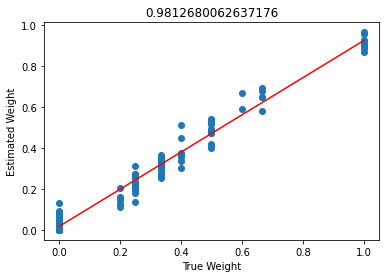

In [7]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

#Calculate relative proportions
Nd = np.sum(mean_post, axis=1) 
Nd = np.asarray([Nd for i in range(n_clusts)]).T 

from scipy.stats import linregress
mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
 
corr_matrix = np.corrcoef(np.ravel(prop_vec), np.ravel(mean_post)) 
corr = corr_matrix[0,1]
R_sq = corr**2
plt.title(R_sq)
plt.show()

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

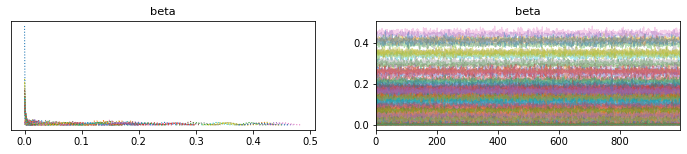

In [25]:
#Visualise posteriors across all proportions
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag
az.plot_trace(idata,combined=True)

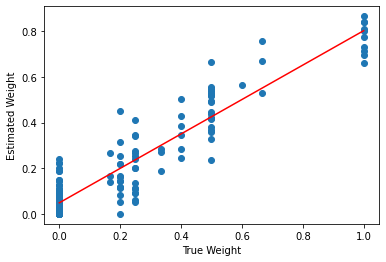

In [27]:
#Check performance
mean_post = np.mean(idata.posterior['beta'][0],axis=0)

#Calculate relative proportions
Nd = np.sum(mean_post, axis=1) 
Nd = np.asarray([Nd for i in range(n_clusts)]).T 

from scipy.stats import linregress
mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)

plt.scatter(np.ravel(prop_vec), np.ravel(mean_post))
plt.xlabel("True Weight")
plt.ylabel("Estimated Weight")

line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))

# Create sequence of 100 numbers from 0 to 100 
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.plot(xseq, line_fit.intercept + line_fit.slope*xseq, 'r',)
plt.annotate("r-squared = {:.3f}".format(line_fit.rvalue**2), (0, 1))
plt.show()

In [4]:
#Poisson GLM with noise
Poisson_noise_GLM=pm.Model()

with Poisson_noise_GLM:

    beta=pm.HalfNormal("beta", sigma=1, shape=(n_spots, n_clusts)) # proportions of each cell at each spot
    eps=pm.Normal("eps", mu= 0, sigma=1, shape=(spots.shape)) # random noise at each spot and gene
    #gamma = pm.Normal("gamma", mu= 0, sigma=1, shape=(spots.shape[1])) # random noise at each gene
    #alpha = pm.Normal("alpha", mu= 0, sigma=1, shape=(spots.shape[0])) # random noise at each spot
    
    lmd=pm.math.dot(beta, ref_exp) #each spot is a linear combination of cell proportions and their reference gene expression
    lmd = lmd + eps #+ np.asarray([gamma.eval() for i in range(spots.shape[0])]) + np.asarray([alpha.eval() for i in range(spots.shape[1])]).T #Add noise

    #Likelihood of observed data given Poisson rates
    y=pm.Poisson("y", mu=lmd, observed=spots)

with Poisson_noise_GLM:
    idata=pm.sample(draws=1000, chains=1)

mean_post = np.mean(idata.posterior['beta'][0],axis=0)
Nd = np.sum(mean_post, axis=1) 
Nd = np.asarray([Nd for i in range(n_clusts)]).T 
mean_post = np.divide(np.mean(idata.posterior['beta'][0],axis=0),Nd)
from scipy.stats import linregress
line_fit=linregress(np.ravel(prop_vec), np.ravel(mean_post))
r2 = line_fit.rvalue

savename = 'RCTD-test_PARSTAND_E-9.npy'
np.save(s_data + 'SPATIAL-TRANSCRIPTOMICS/' + savename, [idata, mean_post, prop_vec, r2])